In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt

console = genjax.pretty(show_locals=False)

2023-06-16 16:57:50.512383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=5.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
from dataclasses import dataclass
from math import pi

import jax
import jax.numpy as jnp

from genjax._src.generative_functions.distributions.distribution import ExactDensity


@dataclass
class GaussianVMFPose(ExactDensity):
    def sample(self, key, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_sample(key, pose_mean, var, concentration)

    def logpdf(self, pose, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_logpdf(pose, pose_mean, var, concentration)

@dataclass
class ImageLikelihood(ExactDensity):
    def sample(self, key, rendered_image, variance, outlier_prob, outlier_volume, **kwargs):
        return rendered_image

    def logpdf(self, image, rendered_image, variance, outlier_prob, outlier_volume, **kwargs):
        return b.threedp3_likelihood(image, rendered_image, variance, outlier_prob, outlier_volume,5)

@dataclass
class ContactParamsUniform(ExactDensity):

    def sample(self, key, low, high):
        return jax.random.uniform(key, shape=(3,)).reshape(-1,1) * (high - low) + low

    def logpdf(self, sampled_val, low, high, **kwargs):
        valid = ((low < sampled_val) & (sampled_val < high))
        log_probs = jnp.log((valid * 1.0) * (jnp.ones_like(sampled_val) / (high-low)))
        return log_probs.sum()

@dataclass
class ContactParamsUniform(ExactDensity):
    def sample(self, key, low, high, arr):
        return jax.random.uniform(key, shape=arr.shape).reshape(-1,1) * (high - low) + low

    def logpdf(self, sampled_val, low, high, arr,**kwargs):
        valid = ((low < sampled_val) & (sampled_val < high))
        log_probs = jnp.log((valid * 1.0) * (jnp.ones_like(sampled_val) / (high-low)))
        return log_probs.sum()

@dataclass
class UniformDiscrete(ExactDensity):
    def sample(self, key, vals, arr):
        return jax.random.choice(key, vals, shape=arr.shape)

    def logpdf(self, sampled_val, vals, arr,**kwargs):
        return jnp.log(1.0 / (vals.shape[0])) * arr.shape[0]


gaussian_vmf_pose = GaussianVMFPose()
image_likelihood = ImageLikelihood()
contact_params_uniform = ContactParamsUniform()
uniform_discrete = UniformDiscrete()

In [5]:
key = jax.random.PRNGKey(10000)


In [9]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
root_poses = jnp.tile(contact_plane[None, ...],(4,1,1))
contact_poses_parallel = jax.vmap(
    b.scene_graph.poses_from_scene_graph,
    in_axes=(None, None, None, 0, None, None), out_axes=1
)

all_box_dims = b.RENDERER.model_box_dims

@genjax.gen
def tabletop_model():
    N = 4
    contact_params = contact_params_uniform(jnp.array([[-0.2,-0.2, 0.0]]), jnp.array([[0.2,0.2, 2*jnp.pi]]), jnp.arange(N)) @ "contact_params"
    indices = uniform_discrete(jnp.arange(0,22), jnp.arange(N)) @ "indices"
    parents = uniform_discrete(jnp.arange(0,1), jnp.arange(N)) @ "parents"
    face_parent = uniform_discrete(jnp.arange(2,3), jnp.arange(N)) @ "face_parent"
    face_child = uniform_discrete(jnp.arange(3,4), jnp.arange(N)) @ "face_child"
    box_dims = all_box_dims[indices]
    poses = b.scene_graph.poses_from_scene_graph(root_poses, box_dims, parents, contact_params, face_parent, face_child)
    rendered_img = b.RENDERER.render_multiobject(
        poses , indices
    )[:,:,:3]

    variance = genjax.distributions.tfp_uniform(0.00001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.00001, 0.001) @ "outlier_prob"
    image = image_likelihood(rendered_img, variance, outlier_prob, 100.0) @ "image"
    return poses

simulate_jit = jax.jit(tabletop_model.simulate)
update_jit = jax.jit(tabletop_model.update)
importance_jit = jax.jit(tabletop_model.importance)
importance_parallel_jit = jax.jit(jax.vmap(tabletop_model.importance, in_axes=(0, None, None)))

In [10]:
def viz_trace_meshcat(trace, colors=None):
    b.clear()
    key = jax.random.PRNGKey(10)
    b.show_cloud("1", trace["image"].reshape(-1,3))
    # noisy_point_cloud_image = jax.random.multivariate_normal(
    #     key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
    # )
    # b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=b.RED)
    if colors is None:
        colors = b.viz.distinct_colors(max(10, len(trace["indices"])))
    for i in range(len(trace["indices"])):
        b.show_trimesh(f"obj_{i}", b.RENDERER.meshes[trace["indices"][i]],color=colors[i])
        b.set_pose(f"obj_{i}", trace.get_retval()[i])

In [11]:
key, trace = simulate_jit(key, ())
key, (_,_,trace,_) = update_jit(key, trace, genjax.choice_map({"parents": jnp.array([-1, 0, 0, 0]), }), ())
print(trace["contact_params"])
print(trace["indices"])
print(trace["parents"])
b.get_depth_image(trace["image"][...,2])


2023-06-16 16:59:18.854288: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2432] Execution of replica 0 failed: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_79388/4240840769.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_79388/4240840769.py'                        │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/traceback_util.py:166 in            │
│ reraise_with_filtered_traceback                                                                  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:238 in cache_miss           │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:185 in _python_pjit_helper  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/core.py:2592 in bind                │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/core.py:363 in bind_with_trace      │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/core.py:817 in process_primitive    │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:1252 in _pjit_call_impl     │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/profiler.py:314 in wrapper          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/interpreters/pxla.py:1916 in        │
│ __call__                                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
XlaRuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [10]:
viz_trace_meshcat(trace)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_77737/3951240132.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_77737/3951240132.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trace' is not defined

In [31]:
contact_plane

Array([[-1.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00,  5.1449579e-01, -8.5749292e-01, -4.6661011e-08],
       [-0.0000000e+00, -8.5749292e-01, -5.1449579e-01,  2.3323808e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32)

In [30]:
trace.get_retval()

Array([[[-1.0000000e+00, -0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00,  5.1449579e-01, -8.5749292e-01, -4.6661011e-08],
        [ 0.0000000e+00, -8.5749292e-01, -5.1449579e-01,  2.3323808e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 5.3425068e-01, -8.4532613e-01, -1.3571800e-07, -3.5881244e-02],
        [-4.3491665e-01, -2.7486959e-01, -8.5749298e-01, -4.0864956e-02],
        [ 7.2486109e-01,  4.5811632e-01, -5.1449567e-01,  2.2660174e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 9.0792716e-01,  4.1912785e-01, -2.5175918e-08, -1.2753282e-01],
        [ 2.1563950e-01, -4.6712458e-01, -8.5749298e-01,  4.1943964e-02],
        [-3.5939929e-01,  7.7854115e-01, -5.1449567e-01,  2.2088196e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-9.8011255e-01, -1.9844198e-01, -7.9165588e-08,  8.7282367e-02],
        [-1.0209756e-01,  5.0426382e-01, -8.5749292e-01, -1.0423212e-01],
        [ 1.7016274e-01, -8.4043956e-01, -5.1449579e-01,  2.3716295e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]],      dtype=float32)

In [262]:
poses = b.scene_graph.poses_from_scene_graph(root_poses, all_box_dims[trace["indices"]], trace["parents"], trace["contact_params"], trace["face_parent"], trace["face_child"])

In [33]:
update_jit = jax.jit(single_object_floating_pose_model.update)

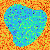

In [37]:
key = jax.random.PRNGKey(10000)
trace = simulate_jit(key, ())[1]
observed_image = trace.get_retval()
noisy_observed_image = observed_image + jax.random.normal(jax.random.PRNGKey(10), observed_image.shape) * 1.0
gt_trace = update_jit(key, trace, genjax.choice_map({"image": noisy_observed_image}), ())[1][2]
b.get_depth_image(gt_trace["image"][:,:,2])


In [38]:
key = jax.random.PRNGKey(1)
score_variance_outlier_prob = lambda trace, v, o: trace.update(key, genjax.choice_map({"variance": v, "outlier_prob" : o}), ())[1][2].get_score()
enumerate_variance_outlier_prob = jax.jit(jax.vmap(jax.vmap(score_variance_outlier_prob, in_axes=(None, None, 0)), in_axes=(None,0, None) ))

(200, 50)
(Array(199, dtype=int32), Array(49, dtype=int32))


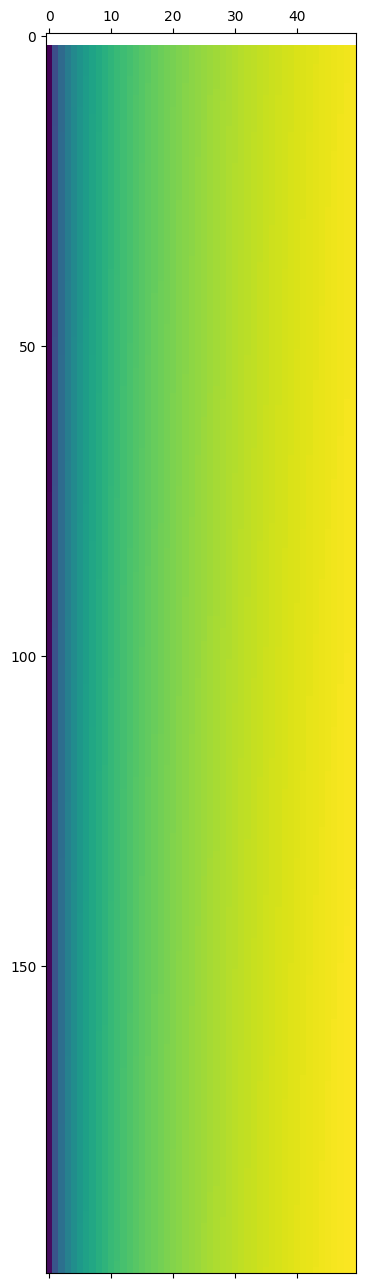

In [40]:
scores = enumerate_variance_outlier_prob(gt_trace, jnp.linspace(0.000001, 0.001, 200),jnp.linspace(0.00001, 0.001, 50))
print(scores.shape)
print(jnp.unravel_index(scores.argmax(), scores.shape))
plt.matshow(scores)

In [97]:
dir(Diff)

[
    '__abstractmethods__',
    '__annotations__',
    '__class__',
    '__dataclass_fields__',
    '__dataclass_params__',
    '__delattr__',
    '__dict__',
    '__dir__',
    '__doc__',
    '__eq__',
    '__format__',
    '__ge__',
    '__getattribute__',
    '__gt__',
    '__hash__',
    '__init__',
    '__init_subclass__',
    '__le__',
    '__lt__',
    '__module__',
    '__ne__',
    '__new__',
    '__reduce__',
    '__reduce_ex__',
    '__repr__',
    '__rich_console__',
    '__rich_repr__',
    '__setattr__',
    '__sizeof__',
    '__str__',
    '__subclasshook__',
    '__weakref__',
    '_abc_impl',
    'flatten',
    'from_tracer',
    'get_primal',
    'get_tracers',
    'inflate',
    'new',
    'slice',
    'stack',
    'sum',
    'unflatten',
    'unstack'
]

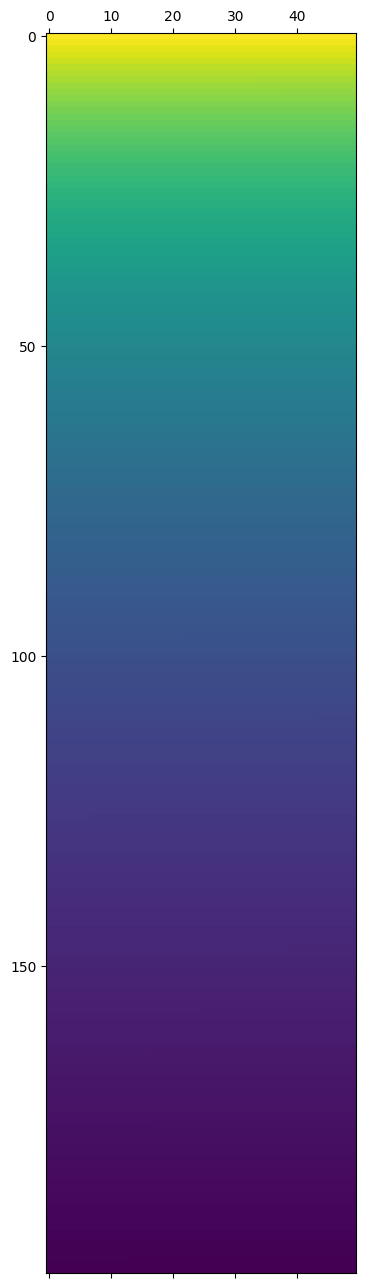

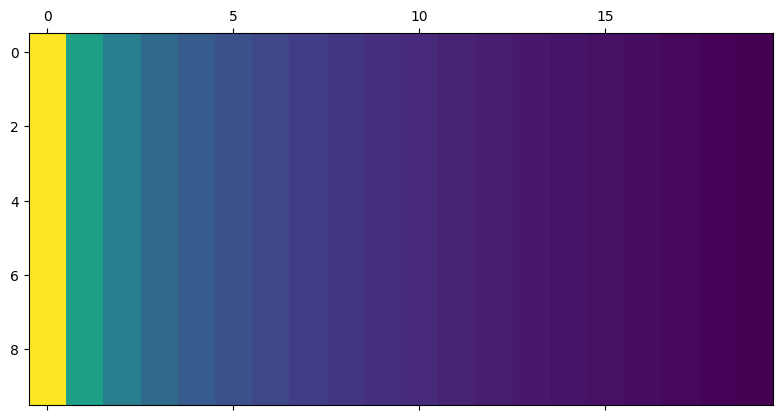

In [9]:
num_samples = 12000
keys = jax.random.split(key, num_samples)
key = keys[0]

[5885 5885 5885 5885 5885 5885 5885 5885 5885 5885]
[-7526.6133 -7526.6133 -7526.6133 -7526.6133 -7526.6133 -7526.6133
 -7526.6133 -7526.6133 -7526.6133 -7526.6133]


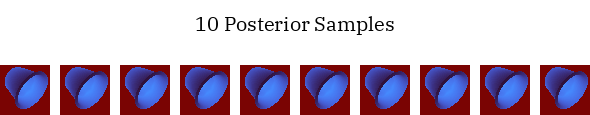

In [10]:
keys, (weights, traces) = importance_parallel_jit(keys, observations, (0.1,0.01, 1.0,))
sampled_indices = jax.random.categorical(key, weights, shape=(10,))
print(sampled_indices)
print(weights[sampled_indices])
images = [b.get_depth_image(img[:,:,2]) for img in traces.get_retval()[sampled_indices]]
b.multi_panel(images,title="10 Posterior Samples", title_fontsize=20)